In [1]:
import gmsh
import meshio
from nodes import Node
from elements import CST
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

import gmsh
import meshio
from nodes import Node
from elements import CST

def load_mesh_objects(geo_file="geo.geo", msh_file="mesh.msh"):
    gmsh.initialize()
    gmsh.open(geo_file)
    gmsh.model.mesh.generate(2)
    gmsh.write(msh_file)
    gmsh.finalize()

    # Leer malla
    mesh = meshio.read(msh_file)

    # Crear nodos
    nodes = [Node(i+1, x, y) for i, (x, y, _) in enumerate(mesh.points)]

    # Crear elementos CST
    cst_elements = []
    for cell_block in mesh.cells:
        if cell_block.type == "triangle":
            for i, node_ids in enumerate(cell_block.data):
                node_ids = [int(id) + 1 for id in node_ids]  # Convertir a índices base 1
                
                cst_elements.append(CST(i+1 , list(node_ids)))
            break

    # Detectar nodos en líneas físicas ("Diritchlet 1" a "Diritchlet 4")
    boundary_nodes = {1: set(), 2: set(), 3: set(), 4: set()}

    for i, cell_block in enumerate(mesh.cells):
        if cell_block.type == "line":
            physical_ids = mesh.cell_data_dict['gmsh:physical']['line']
            for line, phys_id in zip(cell_block.data, physical_ids):
                if phys_id in boundary_nodes:
                    for node_id in line:
                        boundary_nodes[phys_id].add(int(node_id))

    # Añadir etiquetas de borde a los nodos
    for node in nodes:
        node.boundary_label = []
        for label_id, node_set in boundary_nodes.items():
            if node.id in node_set:
                node.boundary_label.append(f"Diritchlet Boundary")

    return nodes, cst_elements


def plot_mesh(nodes, elements, show_node_ids=False, show_elem_ids=False):
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])

    # Convertir elementos CST a array de conectividades
    triangles = np.array([[nid - 1 for nid in elem.node_ids] for elem in elements])


    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    triang = Triangulation(x, y, triangles)
    ax.triplot(triang, color='gray', linewidth=0.8)

    if show_node_ids:
        for node in nodes:
            ax.text(node.x, node.y, str(node.id), color='blue', fontsize=8, ha='center', va='center')

    if show_elem_ids:
        for elem in elements:
            coords = np.array([[nodes[j - 1].x, nodes[j - 1].y] for j in elem.node_ids])

            centroid = coords.mean(axis=0)
            ax.text(*centroid, str(elem.id), color='red', fontsize=8, ha='center')

    ax.set_title("Malla de elementos triangulares (CST)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.tight_layout()
    plt.show()


Info    : Reading 'geo.geo'...
Info    : Done reading 'geo.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00210829s, CPU 0.002008s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.00140254s, CPU 0.001184s)
Info    : 10000 nodes 20002 elements
Info    : Writing 'mesh.msh'...
Info    : Done writing 'mesh.msh'



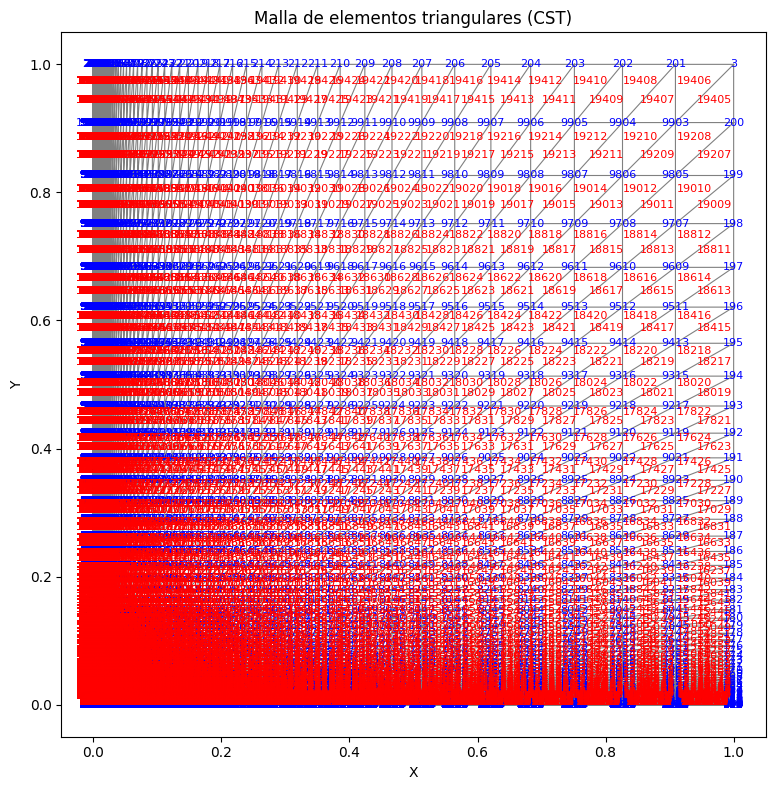

In [2]:
nodes, elements = load_mesh_objects("geo.geo", "mesh.msh")
plot_mesh(nodes, elements, show_node_ids=True, show_elem_ids=True)


In [3]:
#Ahora debo calcular la solucion u
alpha = 1

for node in nodes:
    node.solve_u(alpha)

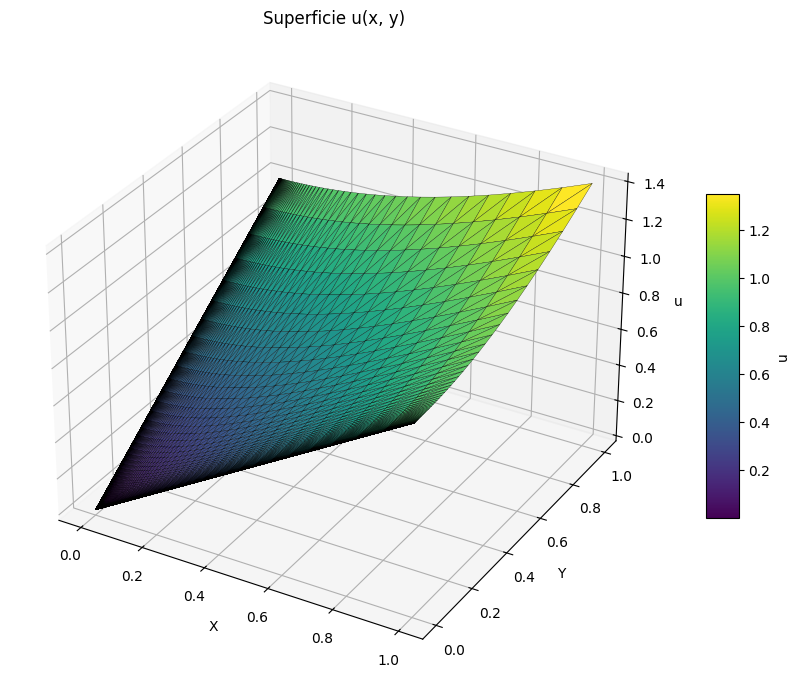

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.tri import Triangulation

def plot_u_surface_from_elements(nodes, elements, use_attr="u"):
    """
    Grafica una superficie 3D de u(x,y) usando la conectividad real de los elementos CST (base 1).
    """
    # Coordenadas de nodos
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    z = np.array([getattr(node, use_attr) for node in nodes])  # puede ser node.u o node.u_fem

    # ⚠️ Convertir de base 1 → base 0
    triangles = np.array([[nid - 1 for nid in elem.node_ids] for elem in elements])

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    tri = Triangulation(x, y, triangles)
    surf = ax.plot_trisurf(tri, z, cmap='viridis', edgecolor='k', linewidth=0.2)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel(use_attr)
    ax.set_title(f"Superficie {use_attr}(x, y)")

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label=use_attr)
    plt.tight_layout()
    plt.show()

plot_u_surface_from_elements(nodes, elements, use_attr="u")       # solución exacta



In [5]:
#Bien, ahora es nesesario ensamblar la stifnes matrix de cada elemento CST
from solve import Solve

Estructure = Solve(nodes, elements, alpha)



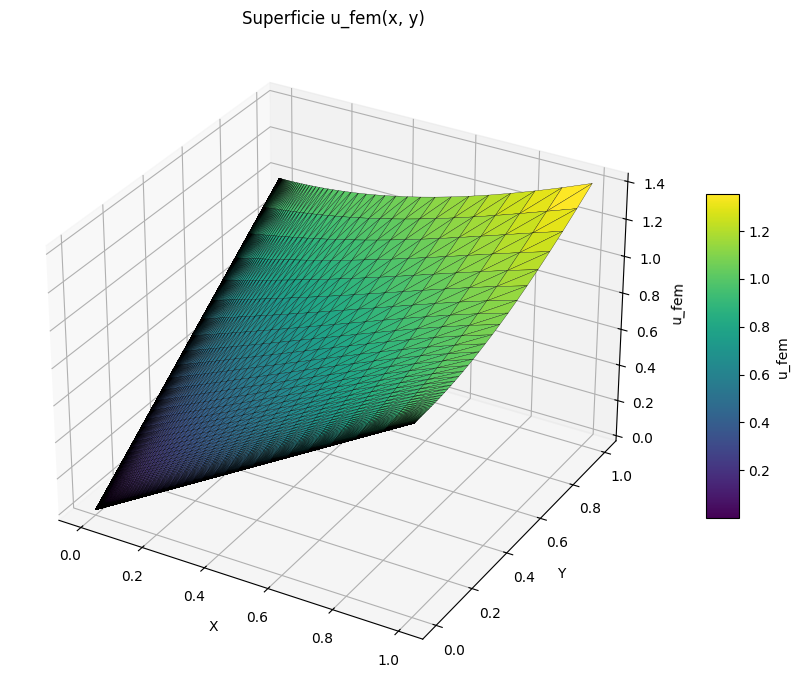

In [6]:
#Bien, ahora es nesesario calcular la solucion,
#Conozco todos lo que esta en la frontera diritchlet
Estructure.solve_matrix()
plot_u_surface_from_elements(nodes, elements, use_attr="u_fem")  # solución FEM



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

def plot_relative_error_surface_3d(nodes, elements):
    """
    Grafica una superficie 3D (no interactiva) del error relativo entre u FEM y u exacto.
    """
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    u_num = np.array([node.u_fem for node in nodes])
    u_ref = np.array([node.u for node in nodes])

    eps = 1e-14
    error_rel = np.abs(u_num - u_ref) / (np.abs(u_ref) + eps)

    # Usar conectividad real (base 1 → base 0)
    triangles = np.array([[nid - 1 for nid in elem.node_ids] for elem in elements])
    triang = Triangulation(x, y, triangles)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_trisurf(triang, error_rel, cmap='plasma', edgecolor='k', linewidth=0.2)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Error relativo')
    ax.set_title('Error relativo nodal entre u FEM y u exacto')

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()

    # Imprimir resumen numérico
    print(f"Máximo error relativo: {np.max(error_rel):.2e}")
    print(f"Promedio error relativo: {np.mean(error_rel):.2e}")
    print(f"Mínimo error relativo: {np.min(error_rel):.2e}")


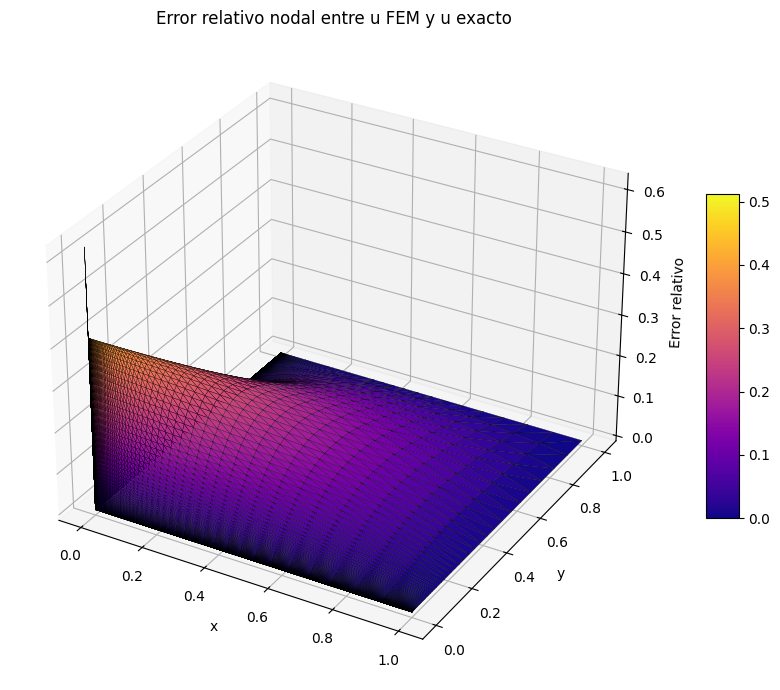

Máximo error relativo: 6.25e-01
Promedio error relativo: 1.02e-01
Mínimo error relativo: 0.00e+00


In [8]:
plot_relative_error_surface_3d(nodes, elements)


In [9]:
for node in nodes:
    print(f"Node {node.id}: u_fem = {node.u_fem:.4f}, u_exact = {node.u:.4f}, Relative Error = {np.abs(node.u_fem - node.u) / (np.abs(node.u) + 1e-14):.2e}")

Node 1: u_fem = 0.0000, u_exact = 0.0000, Relative Error = 0.00e+00
Node 2: u_fem = 1.0000, u_exact = 1.0000, Relative Error = 0.00e+00
Node 3: u_fem = 1.4142, u_exact = 1.4142, Relative Error = 0.00e+00
Node 4: u_fem = 1.0000, u_exact = 1.0000, Relative Error = 0.00e+00
Node 5: u_fem = 0.0000, u_exact = 0.0000, Relative Error = 0.00e+00
Node 6: u_fem = 0.0000, u_exact = 0.0000, Relative Error = 0.00e+00
Node 7: u_fem = 0.0000, u_exact = 0.0000, Relative Error = 0.00e+00
Node 8: u_fem = 0.0000, u_exact = 0.0000, Relative Error = 0.00e+00
Node 9: u_fem = 0.0000, u_exact = 0.0000, Relative Error = 0.00e+00
Node 10: u_fem = 0.0001, u_exact = 0.0001, Relative Error = 0.00e+00
Node 11: u_fem = 0.0001, u_exact = 0.0001, Relative Error = 0.00e+00
Node 12: u_fem = 0.0001, u_exact = 0.0001, Relative Error = 0.00e+00
Node 13: u_fem = 0.0001, u_exact = 0.0001, Relative Error = 0.00e+00
Node 14: u_fem = 0.0001, u_exact = 0.0001, Relative Error = 0.00e+00
Node 15: u_fem = 0.0001, u_exact = 0.0001, 